In [103]:
#!python -m spacy download en_core_web_sm
#!pip install contractions
#!pip install gensim
#!pip install multiprocessing
#!pip install word2vec


In [154]:
import sys
import re
#import pickle
import numpy as np
import pandas as pd
import en_core_web_sm
import spacy
import string
import multiprocessing
import wordcloud.wordcloud as wc
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.manifold import TSNE
from PIL import Image
from contractions import contractions_dict
from collections import Counter
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score, accuracy_score


%matplotlib inline
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

nlp = English()

In [198]:
data=pd.read_csv(r'IMDB Dataset.csv')
data.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to th...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the differ

## PRÉ PROCESSAMENTO

In [3]:
data.shape

(50000, 2)

In [4]:
data = data.dropna(subset=['review'])

In [5]:
sum(data['review'].isna())

0

In [6]:
data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [141]:
data['review'] = data['review'].apply(lambda x:x.replace('<br /><br />', ''))
data['review'] = data['review'].apply(lambda x:x.replace('..', ''))
data['review'] = data['review'].apply(lambda x:x.replace('...', ''))
data['review'] = data['review'].apply(lambda x:x.replace('....', ''))

data.head()

,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to manyAryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and moreso scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows woul...",positive
1,"A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.This movie is slower than a soap opera. and suddenly, Jake decides to become Rambo and kill the zombie.OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them.",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. This being a variation on the Arthur Schnitzler's play about the same

### !! PULAR E CARREGAR O DATASET JÁ NORMALIZADO !!

In [142]:
list_incl = ['etc', 'oz', 'mr', 'mrs', 'em', 's', 'b', 'n', 'd', 'm', 'la',
             't', 'nt', 'll', 'do', 'it', 'dr', 'ex', 'st', 'nd', 'rd', 've' ] ## adicionar algumas stop words

for w in list_incl:
    nlp.vocab[w].is_stop = True

def custom_preprocessor(text):
    text_pp = contraction_expansion(text)
    text_pp = remove_regex(text_pp)
    text_pp = remove_ents(text_pp)
    text_pp = remove_stop_and_punct(text_pp)
    
    return text_pp
    ##return text_pp.split()
    
def remove_regex(text):
    text = re.sub('<.*?>+', '', text) # remover tags html, ex quebra de linha <br>
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

def remove_ents(text):
    doc = nlp(text)
    for ent in doc.ents:
        text = text.replace(ent.text, '')
    return text

def contraction_expansion(text):
    if type(text) is str: 
        for key in contractions_dict:
            value = contractions_dict[key]
            text = text.replace(key, value)
        return text
    else:
        return text
        
def remove_stop_and_punct(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if token.is_stop or token.is_punct or token in stopwords:
          continue
        tokens.append(token.text)
    return ' '.join(tokens)

data['norm_review'] = data['review'].apply(custom_preprocessor)

In [143]:
data['norm_review'][:3]

0     reviewers mentioned watching   episode hooked   right   exactly happened thing struck brutality unflinching scenes violence   set right word   trust   faint hearted timid   pulls punches regards drugs   sex violence   hardcore   classic use word called nickname given oswald maximum security state penitentary   focuses mainly emerald city   experimental section prison cells glass fronts face inwards   privacy high agenda   city home manyaryans   muslims   gangstas   latinos   christians   italians   irish moreso scuffles   death stares   dodgy dealings shady agreements far away main appeal fact goes shows dare   forget pretty pictures painted mainstream audiences   forget charm   forget romance mess   episode saw struck nasty surreal   ready   watched   developed taste   got accustomed high levels graphic violence   violence   injustice   crooked guards sold nickel   inmates kill order away   mannered   middle class inmates turned prison bitches lack street skills prison experienc

In [26]:
data.to_csv(r'IMDB Dataset_norm.csv')

In [197]:
data=pd.read_csv(r'IMDB Dataset_norm.csv')

In [195]:
data.head(3)

,Unnamed: 0,review,sentiment,norm_review
0,0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to manyAryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and moreso scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows woul...",positive,reviewers mentioned watching episode hooked right exactly happened thing struck brutality unflinching scenes violence set right word trust faint hearted timid pulls punches regards drugs sex violence hardcore classic use word called nickname given penitentary focuses mainly experimental section prison cells glass fronts face inwards privacy high agenda home manyaryans gangstas latinos moreso scuffles death stares dodgy dealings shady agreements far away main appeal fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance mess episode saw struck nasty surreal ready watched developed taste got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order away mannered middle class inmates turned prison bitches lack street skills prison experience watching comfortable uncomfortable viewingthats touch darker
1,1,"A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive,wonderful little production filming technique unassuming old time fashion gives comforting discomforting sense realism entire piece actors extremely chosen got polari voices pat truly seamless editing guided references diary entries worth watching terrificly written performed piece masterful production great master comedy life realism comes home little things fantasy guard use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning halliwell sets particularly flat halliwell murals decorating surface terribly
2,2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.This was

In [159]:
x = data.norm_review
y = data.sentiment

vectorizer =  TfidfVectorizer()
x_vec = vectorizer.fit_transform(x)
# values.astype('U') no caso de return split()

# CLUSTER COM KMEANS

<i>Elbow method

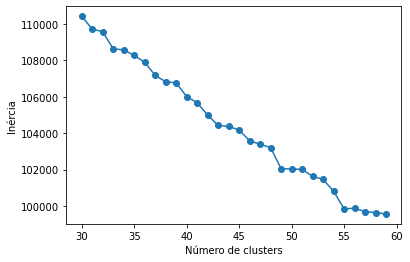

In [171]:
k = list(range(0, 6))
inercia = []

for i in k:
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(bow_matrix)
    inercia.append(kmeans.inertia_)

plt.plot(k, inercia, '-o')
plt.xlabel(r'Número de clusters')
plt.ylabel('Inércia')
plt.show()

<b> Numero ideal de clusters acima de 55/ mas utilizaremos 3 no exemplo.

In [175]:
model = KMeans(n_clusters = 3, random_state = 0)
data['cluster'] = model.fit_predict(x_vec)

Silhouette - índice interno

In [176]:
silhouette_score(x_vec, data['cluster'])

0.0015518315152880104

Rand - índice externo

In [177]:
adjusted_rand_score(y, data['cluster'])

0.006808717801211591

<b> OCORRENCIAS POR CLUSTER

In [131]:
def get_wordlist(data):
  vectorizer = CountVectorizer()
  vector = vectorizer.fit_transform(data)
  word_list = vectorizer.get_feature_names();  
  count_list = vector.toarray().sum(axis=0)
  #word_dict = dict(zip(word_list, count_list))
  word_df = pd.DataFrame({'termo':word_list, 'ocorrencias': count_list})
  return word_df.sort_values(by='ocorrencias', ascending=False).head(100)

In [132]:
get_wordlist(data.norm_review[data.cluster==0].sample(frac=0.3))

,termo,ocorrencias
8789,film,15650
13478,like,3129
15058,movie,2897
9987,good,2462
8813,films,2418
...,...,...
17140,place,399
15440,new,398
16810,performances,396
8492,family,393


In [133]:
get_wordlist(data.norm_review[data.cluster==1].sample(frac=0.3))

,termo,ocorrencias
11322,movie,16060
10140,like,3507
7542,good,2826
11333,movies,2407
1233,bad,2345
...,...,...
14135,recommend,357
7039,found,356
6012,especially,356
6443,fan,352


In [ ]:
## data['doc'] = [nlp(text) for text in data.norm_review]

# BAG OF WORLS

In [13]:
cv = CountVectorizer(strip_accents='unicode', binary=True, max_features=18)
bow_matrix = cv.fit_transform(data.norm_review)
columns = [token[0] for token in sorted(cv.vocabulary_.items(), key=lambda item: item[1])]
pd.DataFrame(bow_matrix.todense(), columns=columns)

,acting,bad,characters,film,good,great,know,like,movie,movies,people,plot,seen,story,think,time,watch,way
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1
3,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0
4,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0,0,0,1,1,1,1,1,1,1,0,1,0,1,0,1,0
49996,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
49997,1,1,0,0,1,0,0,0,1,1,1,0,0,1,0,0,0,0
49998,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0


# VETORIZAÇÃO E MODELAGEM

In [134]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

Text(0.5, 1.0, 'Matrix de confusão')

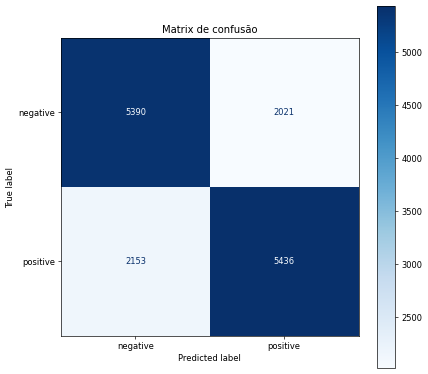

In [19]:
steps = [
    ('vect', CountVectorizer(max_features=1000)),
    ('clf', DecisionTreeClassifier(criterion='entropy', class_weight='balanced', random_state = 42))
]

pipeline = Pipeline(steps)

fig, ax = plt.subplots(figsize=(8, 8), dpi=60)

sentiment_analyzer = pipeline.fit(x_train, y_train)
plot_confusion_matrix(sentiment_analyzer, x_test, y_test, cmap='Blues', values_format='.0f', ax=ax)
plt.title('Matrix de confusão')

In [20]:
cv=CountVectorizer(ngram_range=(1,2))

In [21]:
x_train_trans=cv.fit_transform(x_train)

In [22]:
lr=LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')

In [23]:
lr.fit(x_train_trans,y_train)
pred_y=lr.predict(cv.transform(x_test))

<i>Incrementar max_iter caso erro no fit

In [24]:
score_1=accuracy_score(y_test,pred_y)

#### ACURÁCIA DO MODELO

In [25]:
score_1

0.8891333333333333

# WORLDCLOUD

In [26]:
model = pipeline.named_steps['clf']
vectorizer = pipeline.named_steps['vect']

In [39]:
len(vectorizer.vocabulary_)

1000

In [28]:
count_vec = CountVectorizer()
x = count_vec.fit_transform(x_train)
word_freq_df = pd.DataFrame({'termo': count_vec.get_feature_names(), 
                             'ocorrencias':np.asarray(x.sum(axis=0)).ravel().tolist()})

In [29]:
word_freq_df.sort_values('ocorrencias',ascending = False).head(10)

,termo,ocorrencias
40960,movie,61222
23371,film,55531
36387,like,28030
26742,good,20525
63690,time,17460
60117,story,15795
4388,bad,12924
45998,people,12709
27194,great,12414
69517,way,10844


In [30]:
vocab_dict = dict(zip(list(word_freq_df['termo']),list(word_freq_df['ocorrencias'])))

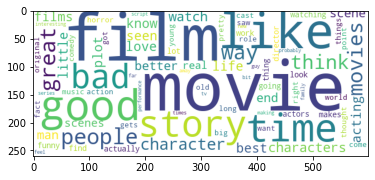

In [31]:
wc_vocab = wc.WordCloud(background_color='white', max_words=80, width=600, height=260).generate_from_frequencies(vocab_dict)
plt.imshow(wc_vocab);

In [32]:
def get_wc(filtered_data):
  count_vec = CountVectorizer()
  vector = count_vec.fit_transform(filtered_data)
  word_list = vectorizer.get_feature_names();
  count_list = vector.toarray().sum(axis=0)
  word_dict = dict(zip(word_list,count_list))
  return (wc.WordCloud(background_color='white', max_words=80, width=400, height=260)
            .generate_from_frequencies(word_dict))

### WORLDCLOUD POR COMENTÁRIOS NEGATIVOS

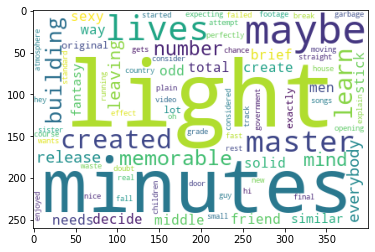

In [33]:
wc_neg = get_wc(data.norm_review[data.sentiment=='negative'])
plt.imshow(wc_neg);

### WORLDCLOUD POR COMENTÁRIOS POSITIVOS

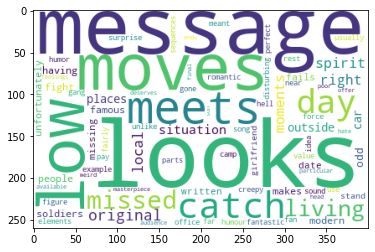

In [34]:
wc_neg = get_wc(data.norm_review[data.sentiment=='positive'])
plt.imshow(wc_neg);

In [179]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['norm_review']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(data)

In [187]:
model = word2vec.Word2Vec(corpus, size=100, window=20, min_count=2200, workers=multiprocessing.cpu_count())

In [192]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    ##tsne_model = TSNE(perplexity=4, n_components=2, init='pca', n_iter=2500, random_state=23)
    tsne_model = TSNE(perplexity=10, n_components=2, init='pca', n_iter=2000, random_state=0)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

<ipython-input-192-3f1b21b15c23>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tokens.append(model[word])


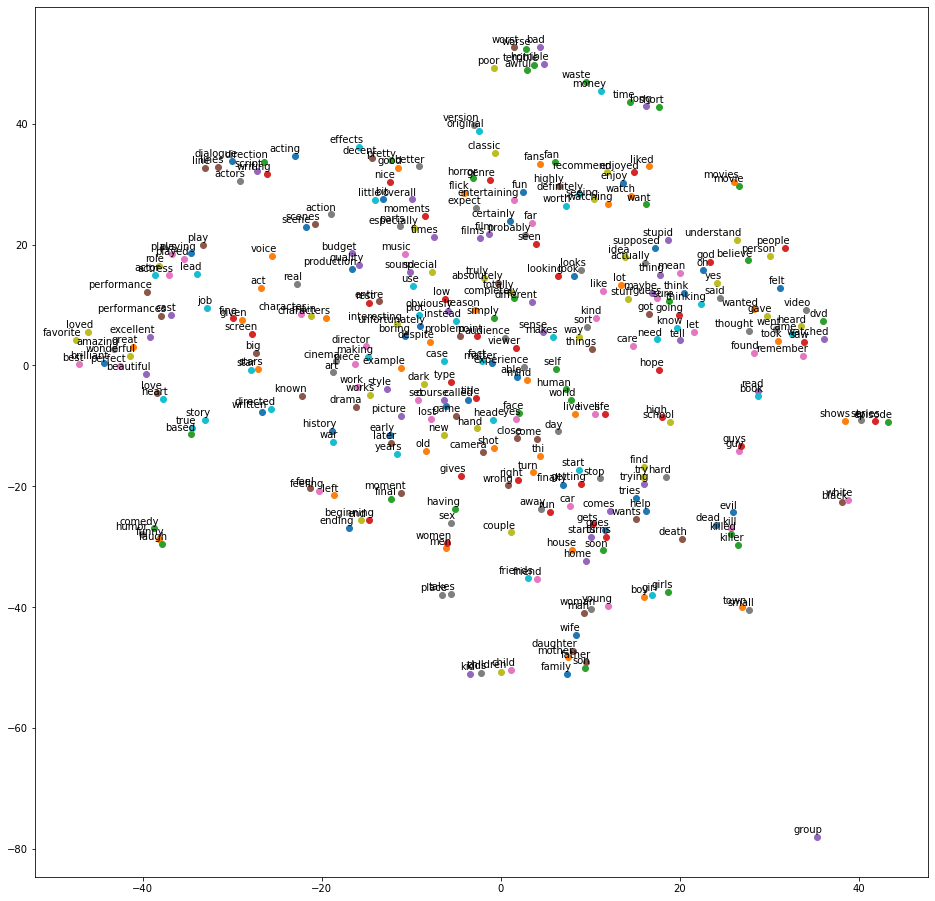

In [193]:
tsne_plot(model)

In [153]:
words = list(model.wv.vocab)
print(words[0:200])

['', 'watching', 'episode', 'right', 'happened', 'thing', 'scenes', 'violence', 'set', 'sex', 'classic', 'use', 'called', 'given', 'face', 'high', 'home', 'death', 'far', 'away', 'main', 'fact', 'goes', 'shows', 'pretty', 'saw', 'watched', 'got', 'kill', 'lack', 'experience', 'wonderful', 'little', 'production', 'old', 'time', 'gives', 'sense', 'entire', 'piece', 'actors', 'extremely', 'truly', 'worth', 'written', 'great', 'comedy', 'life', 'comes', 'things', 'plays', 'particularly', 'thought', 'way', 'plot', 'dialogue', 'characters', 'killer', 'point', 'style', 'love', 'young', 'woman', 'interesting', 'friends', 'family', 'boy', 'movie', 'ok', 'going', 'film', 'drama', 'like', 'real', 'totally', 'instead', 'playing', 'watch', 'human', 'people', 'different', 'play', 'director', 'action', 'person', 'know', 'look', 'taken', 'live', 'world', 'gets', 'picture', 'big', 'best', 'place', 'find', 'case', 'acting', 'good', 'direction', 'rest', 'cast', 'come', 'work', 'probably', 'favorite', 'st

In [190]:
model.most_similar('boring')

<ipython-input-190-7894cd7f9741>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('boring')


[('stupid', 0.5230622887611389),
 ('interesting', 0.44623875617980957),
 ('terrible', 0.42100560665130615),
 ('awful', 0.4009817838668823),
 ('plot', 0.39153221249580383),
 ('horrible', 0.35033172369003296),
 ('worse', 0.34970375895500183),
 ('unfortunately', 0.3413853347301483),
 ('waste', 0.3400324881076813),
 ('instead', 0.3386961817741394)]

In [191]:
model.most_similar('killer')

<ipython-input-191-e3467a3faf4c>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar('killer')


[('killed', 0.584434986114502),
 ('kill', 0.5508491396903992),
 ('dead', 0.4933401346206665),
 ('horror', 0.44755151867866516),
 ('flick', 0.4280117154121399),
 ('turns', 0.42313581705093384),
 ('death', 0.40093377232551575),
 ('starts', 0.3754954934120178),
 ('case', 0.36764633655548096),
 ('goes', 0.33429577946662903)]